## Setup python Environment for Nersc jupyter hub

1) create an isolated python environment namely `tutorial` via [conda](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-with-commands). 

\[Optional\] Create a configuration file for `conda`: `~/.condarc`, 
and specify the location of envrionments that will house python modules. 
This directory will grow very quickly. I suggest to use a project directory.
```json
envs_dirs:
  - /global/cfs/cdirs/atlas/xju/conda/envs
report_errors: true
```

1.1) Following commands is to install an environment named `tutorial`. 
```bash
module load python
conda create -n tutorial python=3.8 ipykernel
source $(which conda | sed -e s#bin/conda#bin/activate#)  tutorial
python -m ipykernel install --user --name tutorial --display-name a-Tutorial
```

It will install a kernel file at `$HOME/.local/share/jupyter/kernels/tutorial/kernel.json`. 

1.2) create a `$HOME/.local/share/jupyter/kernels/tutorial/setup.sh` with the following contents:
```bash
#!/bin/bash
module load python
source $(which conda | sed -e s#bin/conda#bin/activate#)  tutorial
python -m ipykernel_launcher $@
```
and make it executable `chmod +x $HOME/.local/share/jupyter/kernels/tutorial/setup.sh`.

Get absolute path: `readlink -f $HOME/.local/share/jupyter/kernels/tutorial/setup.sh`.

1.3) update the `$HOME/.local/share/jupyter/kernels/tutorial/kernel.json` as the following. 
Note that the path to `setup.sh` should be the absolute path.
```json
{
 "argv": [
  "/global/u1/x/xju/.local/share/jupyter/kernels/tutorial/setup.sh",
  "-f",
  "{connection_file}"
 ],
 "display_name": "a-Tutorial",
 "language": "python"
}
```

In [5]:
!which python
!which pip

/global/homes/x/xju/.conda/envs/tf2.4/bin/python
/global/homes/x/xju/.conda/envs/tf2.4/bin/pip


In [ ]:
!pip install git+https://github.com/xju2/root_gnn.git

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets import graphs as Graphs

import itertools
from typing import Optional

In [2]:
def print_graphs_tuple(g, data=True):
    for field_name in Graphs.ALL_FIELDS:
        per_replica_sample = getattr(g, field_name)
        if per_replica_sample is None:
            print(field_name, "EMPTY")
        else:
            print(field_name, "is with shape", per_replica_sample.shape)
            if data and  field_name != "edges":
                print(per_replica_sample)

### Creating graphs from networkx

[networkx](https://networkx.org/documentation/stable/tutorial.html) is a Python package for the study of graphs.


In [3]:
g = nx.DiGraph()

# add nodes
[g.add_node(idx, features=np.array([1.*idx])) for idx in range(4)];

# add edges
edge_lists = [(0, 1), (1, 2), (2, 3), (3, 0)]
[g.add_edge(i, j, features=np.array([abs(i-j)])) for i,j in edge_lists];

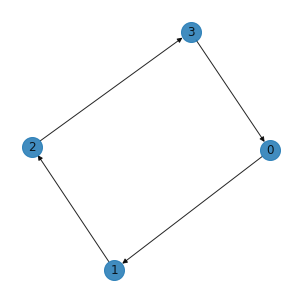

In [4]:
plt.figure(figsize=(4, 4))
pos = nx.spring_layout(g)
nx.draw(g, pos, node_size=400, alpha=0.85, node_color="#1f78b4", with_labels=True)

obtain the adjacency matrix

In [5]:
adj = np.asarray(nx.to_numpy_matrix(g))
adj

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [6]:
g.edges()

OutEdgeView([(0, 1), (1, 2), (2, 3), (3, 0)])

In [7]:
g_tuple = utils_np.networkxs_to_graphs_tuple([g])

In [8]:
g_tuple

GraphsTuple(nodes=array([[0.],
       [1.],
       [2.],
       [3.]]), edges=array([[1],
       [1],
       [1],
       [3]]), receivers=array([1, 2, 3, 0], dtype=int32), senders=array([0, 1, 2, 3], dtype=int32), globals=None, n_node=array([4], dtype=int32), n_edge=array([4], dtype=int32))

In [9]:
print_graphs_tuple(g_tuple)

nodes is with shape (4, 1)
[[0.]
 [1.]
 [2.]
 [3.]]
edges is with shape (4, 1)
receivers is with shape (4,)
[1 2 3 0]
senders is with shape (4,)
[0 1 2 3]
globals EMPTY
n_node is with shape (1,)
[4]
n_edge is with shape (1,)
[4]


### Create GraphsTuple using data-dict \[recommend\]

In [10]:
n_node = 4
n_node_features = 1
n_edge = 4
n_edge_features = 1
nodes = np.random.rand(n_node, n_node_features).astype(np.float32)
edges = np.random.rand(n_edge, n_edge_features).astype(np.float32)
receivers = np.array([1, 2, 3, 0])
senders = np.array([0, 1, 2, 3])
datadict = {
    "n_node": n_node,
    "n_edge": n_edge,
    "nodes": nodes,
    "edges": edges,
    "senders": senders,
    "receivers": receivers,
    "globals": np.array([0], dtype=np.float32)
}

In [11]:
g_tuple2 = utils_tf.data_dicts_to_graphs_tuple([datadict])

In [12]:
print_graphs_tuple(g_tuple2)

nodes is with shape (4, 1)
tf.Tensor(
[[0.859495  ]
 [0.0219777 ]
 [0.09030578]
 [0.4027286 ]], shape=(4, 1), dtype=float32)
edges is with shape (4, 1)
receivers is with shape (4,)
tf.Tensor([1 2 3 0], shape=(4,), dtype=int32)
senders is with shape (4,)
tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
globals is with shape (1, 1)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)
n_node is with shape (1,)
tf.Tensor([4], shape=(1,), dtype=int32)
n_edge is with shape (1,)
tf.Tensor([4], shape=(1,), dtype=int32)


### Convert an event to a fully-connected graph

We take the top tagger dataset as an example: [https://zenodo.org/record/2603256](https://zenodo.org/record/2603256).

In [13]:
# change to the directory you saved the data.
filename = '/global/homes/x/xju/atlas/data/top-tagger/test.h5'

In [14]:
with pd.HDFStore(filename, mode='r') as store:
    df = store['table']

In [15]:
df.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
436,218.364243,-172.341858,110.129105,-76.503624,153.661118,-111.320465,93.167969,-50.390713,76.708054,-56.523701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
440,122.238762,26.738468,-91.613998,76.382225,121.227135,17.644758,-93.015450,75.715302,90.420105,21.377417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
441,383.772308,-97.906456,79.640709,-362.426361,200.625992,-54.921326,37.994343,-189.184753,123.247223,-33.828953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
444,132.492752,-77.763947,-87.322601,-62.304600,83.946594,-49.450481,-53.823605,-41.288010,28.072624,-19.964916,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
445,730.786987,-209.120010,-193.454315,-672.973877,225.477325,-75.363350,-66.226990,-201.926651,217.040192,-63.698189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [16]:
event = df.iloc[0]
event

E_0              218.364243
PX_0            -172.341858
PY_0             110.129105
PZ_0             -76.503624
E_1              153.661118
                    ...    
truthPX            0.000000
truthPY            0.000000
truthPZ            0.000000
ttv                1.000000
is_signal_new      0.000000
Name: 436, Length: 806, dtype: float64

In [17]:
features = ['E', 'PX', 'PY', 'PZ']
scale = 0.001
solution = 'is_signal_new'

def make_graph(event, debug: Optional[bool] = False):
    n_max_nodes = 200
    n_nodes = 0
    nodes = []
    for inode in range(n_max_nodes):
        E_name = 'E_{}'.format(inode)
        if event[E_name] < 0.1:
            continue

        f_keynames = ['{}_{}'.format(x, inode) for x in features]
        n_nodes += 1
        nodes.append(event[f_keynames].values*scale)
    nodes = np.array(nodes, dtype=np.float32)

    # to make a bi-directional fully connected graph
    all_edges = list(itertools.combinations(range(n_nodes), 2))
    senders = np.array([x[0] for x in all_edges])
    receivers = np.array([x[1] for x in all_edges])
    n_edges = len(all_edges)
    edges = np.expand_dims(np.array([0.0]*n_edges, dtype=np.float32), axis=1)

    input_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([n_nodes], dtype=np.float32)
    }
    target_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([event[solution]], dtype=np.float32)
    }
    input_graph = utils_tf.data_dicts_to_graphs_tuple([input_datadict])
    target_graph = utils_tf.data_dicts_to_graphs_tuple([target_datadict])
    return [(input_graph, target_graph)]

In [18]:
graphs = make_graph(event)

In [19]:
g_evt_input, g_evt_target = graphs[0]

In [20]:
print_graphs_tuple(g_evt_input, data=False)

nodes is with shape (17, 4)
edges is with shape (136, 1)
receivers is with shape (136,)
senders is with shape (136,)
globals is with shape (1, 1)
n_node is with shape (1,)
n_edge is with shape (1,)


In [21]:
17*16//2

136

In [22]:
g_evt_target.globals

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

Convert all events into graphs and save these graphs for training

In [23]:
def read(filename):
    with pd.HDFStore(filename, mode='r') as store:
        df = store['table']

    for ievt in range(df.shape[0]):
        yield df.iloc[ievt]

In [24]:
from root_gnn.src.datasets.base import DataSet

In [25]:
class TopTaggerDataset(DataSet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.read = read
        self.make_graph = make_graph

    def _num_evts(self, filename):
        with pd.HDFStore(filename, mode='r') as store:
            df = store['table']
        return df.shape[0]

In [26]:
data = TopTaggerDataset()

In [27]:
tr_filename = '/global/homes/x/xju/atlas/data/top-tagger/train.h5'
n_evts_per_record = 10
debug = False
max_evts = 100
num_workers = 1
overwrite = False

In [28]:
# using multiprocessing in jupyter notebook seems problematic..
# It is a slow process. Suggest adding the new DataSet class to root_gnn.dataset
# and use the `create_tfrecord` script to process the events

data.process(filename=tr_filename, outname="TopTagger/trainning",\
    n_evts_per_record=n_evts_per_record, debug=debug,
    max_evts=max_evts, num_workers=num_workers, overwrite=overwrite)

Total 100 events are requested to be written to 10 files with 1 workers
TopTaggerDataset added 100 events, in 4.6 mins
0 events failed in being converted to graph


In [29]:
!ls TopTagger

trainning_0.tfrec  trainning_3.tfrec  trainning_6.tfrec  trainning_9.tfrec
trainning_1.tfrec  trainning_4.tfrec  trainning_7.tfrec
trainning_2.tfrec  trainning_5.tfrec  trainning_8.tfrec


In [30]:
!split_files_for_nn TopTagger inputs

2021-07-06 23:17:05.049322: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Shuffling input files
Total 10 files
Training   8 files
Validation 1 files
Testing    1 files


In [31]:
!ls inputs

test  train  val


### 3. Training GNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets import graphs as Graphs
import sonnet as snt

import itertools
from typing import Optional


from root_gnn import model as Models
from root_gnn import losses
from root_gnn.trainer import Trainer

INFO:tensorflow:TF Version:2.4.0


In [2]:
print(Models.__file__)

/global/homes/x/xju/.conda/envs/tf2.4/lib/python3.8/site-packages/root_gnn/model.py


In [10]:
model = Models.GlobalClassifier(encoder_size=[256, 256], core_size=[256, 256], decoder_size=[256, 256])

In [11]:
loss_fcn = losses.GlobalLoss(real_global_weight=1., fake_global_weight=1.)

In [5]:
learning_rate = 0.0005
optimizer = snt.optimizers.Adam(learning_rate)

In [6]:
!ls /global/homes/x/xju/atlas/TopTagger/inputs/val

train_105.tfrec  train_177.tfrec  train_214.tfrec  train_34.tfrec
train_113.tfrec  train_190.tfrec  train_217.tfrec  train_3.tfrec
train_14.tfrec	 train_205.tfrec  train_219.tfrec  train_49.tfrec
train_157.tfrec  train_209.tfrec  train_226.tfrec  train_59.tfrec
train_160.tfrec  train_212.tfrec  train_235.tfrec  train_73.tfrec
train_161.tfrec  train_213.tfrec  train_28.tfrec   train_98.tfrec


In [7]:
!which python

/global/homes/x/xju/.conda/envs/tf2.4/bin/python


In [14]:
# mode, -> 'rgr,globals', ['clf', 'rgr'], ['globals', 'edges']
trainer = Trainer(input_dir="/global/homes/x/xju/atlas/TopTagger/inputs",
                  output_dir="/global/homes/x/xju/atlas/TopTagger/trainedTopTagger2",
                  model=model, loss_fcn=loss_fcn, optimizer=optimizer,
                  evts_per_file=5000, mode='clf,globals', batch_size=10,
                  val_batches=10, log_freq=10, patiences=10,
                 )

In [15]:
## training for 100 batches
trainer.train(100)

INFO:tensorflow:Loading latest checkpoint from: /global/homes/x/xju/atlas/TopTagger/trainedTopTagger2/checkpoints


  0%|          | 0/100 [00:00<?, ?it/s]

Training starts with 970000 graphs with batch size of 10 for 1 epochs
runing 100 steps, 97000 steps per epoch, and stop on variable val_loss
Tracing update_step


  1%|          | 1/100 [00:08<13:34,  8.23s/it]

>>>1,908,481 trainable parameters<<<


 10%|█         | 10/100 [00:23<01:26,  1.04it/s, acc=0.87, auc=0.956, loss=0.349, pre=0.718, rec=0.933, val_loss=0.273]

100%|██████████| 100/100 [02:27<00:00,  1.48s/it, acc=0.74, auc=0.904, loss=0.453, pre=0.886, rec=0.65, val_loss=0.516]


In [16]:
trainer.load_testing_data()

In [19]:
from root_gnn.utils_plot import plot_metrics

In [24]:
predictions, truth_info = [], []
for _ in range(100):
    inputs, targets = next(trainer.data_test)
    outputs = trainer.model(inputs, trainer.num_iters, is_training=False)
    output = outputs[-1]
    predictions.append(output.globals)
    truth_info.append(targets.globals)

In [25]:
predictions = np.concatenate(predictions, axis=0)
truth_info = np.concatenate(truth_info, axis=0)

In [27]:
predictions.shape

(1000, 1)

                     0.10    0.50    0.80
Accuracy:            0.8280 0.7670 0.4770
Precision (purity):  0.7716 0.9138 1.0000
Recall (efficiency): 0.9764 0.6364 0.0491
AUC: 0.9271


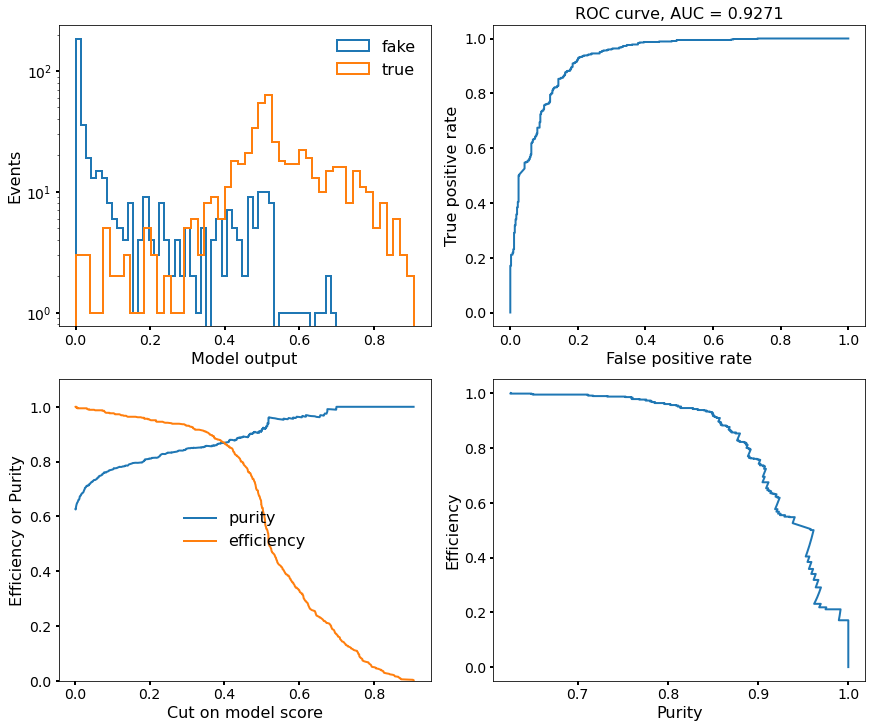

In [26]:
plot_metrics(np.array(predictions), np.array(truth_info))